In [53]:
# Training with vgg 16 model

In [ ]:
# model saved:- vgg 16
# model save:- efficientnetb0

In [11]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [27]:
# Define the paths
base_image_dir = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images'
labels_path = 'Downloads/archive/train.csv'

In [28]:
# Load the labels
labels_df = pd.read_csv(labels_path)

# Map the labels to the corresponding directories
label_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}

In [29]:
# Create image paths and labels
image_paths = []
labels = []
for index, row in labels_df.iterrows():
    image_filename = row['id_code']
    label = row['diagnosis']
    image_path = os.path.join(base_image_dir, f"{label_map[label]}/{image_filename}.png")
    image_paths.append(image_path)
    labels.append(label)

In [30]:
# Split the dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [31]:
# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

In [32]:
# Function to preprocess a single image
def preprocess_image(image_path, target_size):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [33]:
# Data generator for training
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def train_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

In [34]:
# Data generator for validation
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def val_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

In [35]:
# Load the VGG16 model without the top layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

In [36]:
# Freeze the layers in the base model
for layer in vgg16_base.layers:
    layer.trainable = False

In [37]:
# Add custom layers on top of VGG16
x = Flatten()(vgg16_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for the diabetic retinopathy levels

In [38]:
# Create the model
model = Model(inputs=vgg16_base.input, outputs=output)

In [39]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [61]:
# Train the model
history = model.fit(
    train_generator(X_train_paths, y_train, batch_size, image_size),
    steps_per_epoch=len(X_train_paths) // batch_size,
    validation_data=val_generator(X_val_paths, y_val, batch_size, image_size),
    validation_steps=len(X_val_paths) // batch_size,
    epochs=30  # Adjust the number of epochs as needed
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 611ms/step - accuracy: 0.4979 - loss: 1.3060 - val_accuracy: 0.4844 - val_loss: 1.2907
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 53s 591ms/step - accuracy: 0.4980 - loss: 1.3070 - val_accuracy: 0.4765 - val_loss: 1.3016
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 568ms/step - accuracy: 0.5005 - loss: 1.3086 - val_accuracy: 0.4750 - val_loss: 1.3034
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 51s 563ms/step - accuracy: 0.4902 - loss: 1.3199 - val_accuracy: 0.4864 - val_loss: 1.2845
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 568ms/step - accuracy: 0.4913 - loss: 1.3178 - val_accuracy: 0.4765 - val_loss: 1.2945
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 572ms/step - accuracy: 0.4918 - loss: 1.3200 - val_accuracy: 0.4736 - val_loss: 1.2998
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 574ms/step - accuracy: 0.5080 - loss: 1.2981 - val_accuracy: 0.4779 - val_loss: 1.2985
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 575ms/step - accuracy: 0.5017 - loss: 1.3001 - val_accu

In [66]:
model.save('Downloads/modelsaved.keras')

In [46]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     -------- ---------------------------- 61.4/275.7 kB 297.7 kB/s eta 0:00:01
     ------------ ------------------------ 92.2/275.7 kB 403.5 kB/s eta 0:00:01
     ------------ ------------------------ 92.2/275.7 kB 403.5 kB/s eta 0:00:01
     ------------ ------------------------ 92.2/275.7 kB 403.5 kB/s eta 0:00:01
     ------------------------- ---------- 194.6/275.7 kB 512.0 kB/s eta 0:00:01
     ----------------------------- ------ 225.3/275.7 kB 550.0 kB/s eta 0:00:01
     ----------------------------- ------ 225.3/275.7 kB 550.0 kB/s eta 0:00:01
     ---------------------------------- - 266.2/275.7 kB 512.0 kB/s eta 0:00:01
     ---------------------------------- - 266.2/275.7 kB 512.0 kB

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


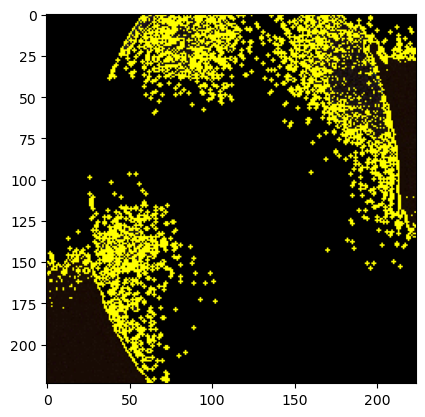

In [67]:
import lime
from lime import lime_image
import keras
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy

def transform_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Load your model here without the optimizer state to avoid the warning
model = keras.models.load_model('Downloads/modelsaved.keras', compile=False)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to your image
img_path = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png'
img = transform_image(img_path)

# Explanation
explanation = explainer.explain_instance(img[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Display the explanation
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp = temp / 255.0 if temp.max() > 1 else temp  # Normalize the image data
plt.imshow(mark_boundaries(temp, mask))
plt.show()


In [49]:
!pip install shap

   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
    --------------------------------------- 10.2/456.1 kB ? eta -:--:--
    --------------------------------------- 10.2/456.1 kB ? eta -:--:--
    --------------------------------------- 10.2/456.1 kB ? eta -:--:--
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/456.1 kB 459.5 kB/s eta 0

C:\Users\shaur\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


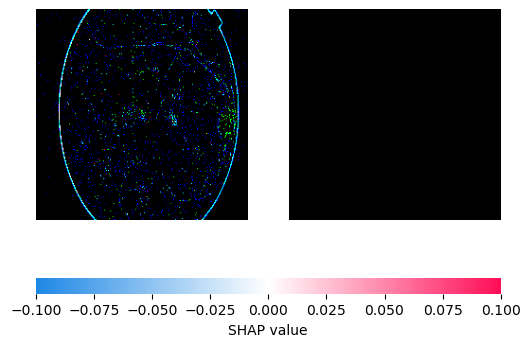

In [50]:
import shap

# Assuming 'model' is your VGG16 model and 'transform_image' is your image preprocessing function

# Load a batch of images
images = np.array([transform_image('Downloads/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png').reshape((224, 224, 3)) for i in range(10)])

# Create a SHAP explainer object using a background dataset
background = images[:1]
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(images[:1])

# Plot the SHAP values for the first class (change the index for different classes)
shap.image_plot(shap_values, -images[:1])

In [68]:
# Print the training and validation accuracies for VGG16 model
print("VGG16 Model Accuracy:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

VGG16 Model Accuracy:
Training Accuracy: 0.4974
Validation Accuracy: 0.4779


In [63]:
# Training with efficient net b0 model
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the paths
base_image_dir = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images'
labels_path = 'Downloads/archive/train.csv'

# Load the labels
labels_df = pd.read_csv(labels_path)

# Map the labels to the corresponding directories
label_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}

# Create image paths and labels
image_paths = []
labels = []
for index, row in labels_df.iterrows():
    image_filename = row['id_code']
    label = row['diagnosis']
    image_path = os.path.join(base_image_dir, f"{label_map[label]}/{image_filename}.png")
    image_paths.append(image_path)
    labels.append(label)

# Split the dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

# Function to preprocess a single image
def preprocess_image(image_path, target_size):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Data generator for training
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def train_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

# Data generator for validation
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0)

def val_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

# Load the EfficientNetB0 model without the top layer
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the layers in the base model
for layer in efficientnet_base.layers:
    layer.trainable = False

# Add custom layers on top of EfficientNet
x = GlobalAveragePooling2D()(efficientnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for the diabetic retinopathy levels

# Create the model
model = Model(inputs=efficientnet_base.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history_efficientnetb0 = model.fit(
    train_generator(X_train_paths, y_train, batch_size, image_size),
    steps_per_epoch=len(X_train_paths) // batch_size,
    validation_data=val_generator(X_val_paths, y_val, batch_size, image_size),
    validation_steps=len(X_val_paths) // batch_size,
    epochs=30  # Adjust the number of epochs as needed
)

# Save the model
model.save('Downloads/modelsave.keras')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,708,008 (17.96 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 89s 663ms/step - accuracy: 0.4620 - loss: 1.3628 - val_accuracy: 0.4844 - val_loss: 1.3018
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 576ms/step - accuracy: 0.4972 - loss: 1.3027 - val_accuracy: 0.4765 - val_loss: 1.3054
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 570ms/step - accuracy: 0.4996 - loss: 1.3106 - val_accuracy: 0.4750 - val_loss: 1.3049
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 595ms/step - accuracy: 0.4902 - loss: 1.3208 - val_accuracy: 0.4864 - val_loss: 1.2837
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 54s 595ms/step - accuracy: 0.4913 - loss: 1.3247 - val_accuracy: 0.4765 - val_loss: 1.2949
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.4918 - loss: 1.3247 - val_accuracy: 0.4736 - val_loss: 1.2996
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 604ms/step - accuracy: 0.5080 - loss: 1.3025 - val_accuracy: 0.4779 - val_loss: 1.2994
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.5017 - loss: 1.3064 - val_accu

C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


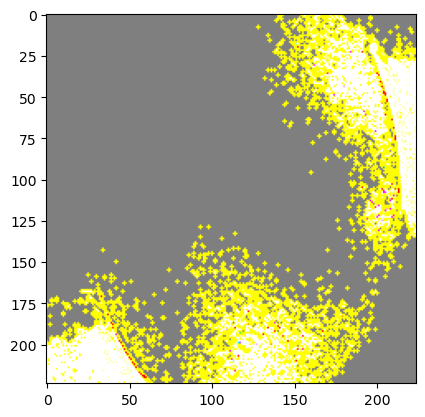

In [65]:
import lime
from lime import lime_image
import keras
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import matplotlib.pyplot as plt

def transform_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Load your model here
model = keras.models.load_model('Downloads/modelsave.keras')

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to your image
img_path = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png'
img = transform_image(img_path)

# Explanation
explanation = explainer.explain_instance(img[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Display the explanation
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

In [69]:
# Print the training and validation accuracies for the EfficientNetB0 model
print("\nEfficientNetB0 Model Accuracy:")
print(f"Training Accuracy: {history_efficientnetb0.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history_efficientnetb0.history['val_accuracy'][-1]:.4f}")


EfficientNetB0 Model Accuracy:
Training Accuracy: 0.4974
Validation Accuracy: 0.4779


In [70]:
# Training using ResNet50
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the paths
base_image_dir = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images'
labels_path = 'Downloads/archive/train.csv'

# Load the labels
labels_df = pd.read_csv(labels_path)

# Map the labels to the corresponding directories
label_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}

# Create image paths and labels
image_paths = []
labels = []
for index, row in labels_df.iterrows():
    image_filename = row['id_code']
    label = row['diagnosis']
    image_path = os.path.join(base_image_dir, f"{label_map[label]}/{image_filename}.png")
    image_paths.append(image_path)
    labels.append(label)

# Split the dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

# Function to preprocess a single image
def preprocess_image(image_path, target_size):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Data generator for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def train_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

# Data generator for validation
val_datagen = ImageDataGenerator()

def val_generator(X_paths, y, batch_size, image_size):
    while True:
        for start in range(0, len(X_paths), batch_size):
            end = min(start + batch_size, len(X_paths))
            X_batch_paths = X_paths[start:end]
            y_batch = y[start:end]
            X_batch = np.array([preprocess_image(img_path, image_size) for img_path in X_batch_paths])
            yield X_batch, np.array(y_batch)

# Load the ResNet50 model without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the layers in the base model
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for the diabetic retinopathy levels

# Create the model
model = Model(inputs=resnet_base.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator(X_train_paths, y_train, batch_size, image_size),
    steps_per_epoch=len(X_train_paths) // batch_size,
    validation_data=val_generator(X_val_paths, y_val, batch_size, image_size),
    validation_steps=len(X_val_paths) // batch_size,
    epochs=10  # Adjust the number of epochs as needed
)

# Save the model
model.save('Downloads/modelsaveresnet.keras')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator(X_val_paths, y_val, batch_size, image_size), steps=len(X_val_paths) // batch_size)
print(f"Validation Accuracy: {val_accuracy}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 464s 5us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4997 - loss: 1.4094 - val_accuracy: 0.6591 - val_loss: 0.9659
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6175 - loss: 1.0077 - val_accuracy: 0.6676 - val_loss: 0.9641
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6287 - loss: 0.9798 - val_accuracy: 0.6605 - val_loss: 0.9754
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6344 - loss: 0.9832 - val_accuracy: 0.6790 - val_loss: 0.9184
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6344 - loss: 0.9751 - val_accuracy: 0.6776 - val_loss: 0.9321
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6278 - loss: 0.9732 - val_accuracy: 0.6733 - val_loss: 0.9179
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6418 - loss: 0.9563 - val_accuracy: 0.6719 - val_loss: 0.9316
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6428 - loss: 0.9578 - val_accuracy: 0.6662 - val_lo

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

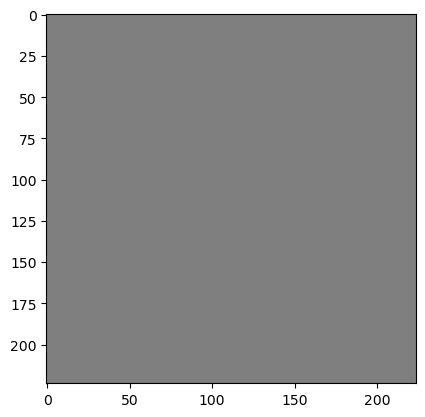

In [81]:
import lime
from lime import lime_image
import keras
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import matplotlib.pyplot as plt

def transform_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Load your model here
model = keras.models.load_model('Downloads/modelsaveresnet.keras')

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to your image
img_path = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/00a8624548a9.png'
img = transform_image(img_path)

# Explanation
explanation = explainer.explain_instance(img[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Display the explanation
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

In [78]:
# Print the training and validation accuracies for the resnet model
print("\nEfficientNetB0 Model Accuracy:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


EfficientNetB0 Model Accuracy:
Training Accuracy: 0.6527
Validation Accuracy: 0.6790


In [4]:
# Our custom cnn model

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import shutil

In [14]:
# Load and preprocess the CSV file
df = pd.read_csv('Downloads/archive/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [15]:
# Split into stratified train, validation, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'])
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['type'])

In [16]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

In [17]:
# Copy images to respective directories
src_dir = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    id_code = row['id_code'] + ".png"
    dstfile = os.path.join(train_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(os.path.join(src_dir, row['type'], id_code), dstfile)

for index, row in val.iterrows():
    id_code = row['id_code'] + ".png"
    dstfile = os.path.join(val_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(os.path.join(src_dir, row['type'], id_code), dstfile)

for index, row in test.iterrows():
    id_code = row['id_code'] + ".png"
    dstfile = os.path.join(test_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(os.path.join(src_dir, row['type'], id_code), dstfile)

In [18]:
# Setting up ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_batches = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_batches = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [19]:
# Load the VGG16 model with pretrained weights
base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the pretrained layers

In [44]:
# Build the model
model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),

    base_model,  # Add VGG16 as the base model
    layers.Flatten(),  # Flatten the output from the VGG16 model

    # Add additional dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])


In [21]:
# Compile the model with a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
# Train the model
history = model.fit(train_batches, epochs=10, validation_data=val_batches, callbacks=[early_stopping])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 618s 8s/step - accuracy: 0.9397 - loss: 0.1760 - val_accuracy: 0.9364 - val_loss: 0.2064
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 620s 8s/step - accuracy: 0.9456 - loss: 0.1762 - val_accuracy: 0.9509 - val_loss: 0.1853
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 623s 8s/step - accuracy: 0.9377 - loss: 0.1916 - val_accuracy: 0.9636 - val_loss: 0.1220
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 623s 8s/step - accuracy: 0.9556 - loss: 0.1425 - val_accuracy: 0.9691 - val_loss: 0.1666
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 624s 8s/step - accuracy: 0.9591 - loss: 0.1390 - val_accuracy: 0.9636 - val_loss: 0.1255
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 648s 8s/step - accuracy: 0.9568 - loss: 0.1442 - val_accuracy: 0.9400 - val_loss: 0.2343
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.9567 - loss: 0.1335 - val_accuracy: 0.9655 - val_loss: 0.1185
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 606s 7s/step - accuracy: 0.9552 - loss: 0.1406 - val_accuracy: 0.9618 - v

In [28]:
# Optionally, fine-tune the base model by unfreezing the layers
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
# Fine-tune the model
history_fine = model.fit(train_batches, epochs=5, validation_data=val_batches, callbacks=[early_stopping])

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9604 - loss: 0.1293 - val_accuracy: 0.9636 - val_loss: 0.1210
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 603s 7s/step - accuracy: 0.9594 - loss: 0.1367 - val_accuracy: 0.9655 - val_loss: 0.1194
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 598s 7s/step - accuracy: 0.9531 - loss: 0.1678 - val_accuracy: 0.9309 - val_loss: 0.2128
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.9513 - loss: 0.1497 - val_accuracy: 0.9636 - val_loss: 0.1740
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9572 - loss: 0.1286 - val_accuracy: 0.9691 - val_loss: 0.1290


In [31]:
model.save('Downloads/vgg16_custom_model.keras')

In [33]:
loss, acc = model.evaluate(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9698 - loss: 0.0974
Accuracy:  0.9745454788208008


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

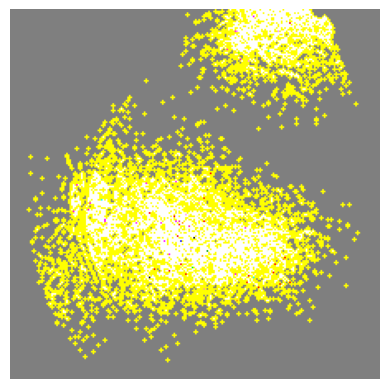

In [51]:
# Load the model
# new_model = tf.keras.models.load_model('Downloads/vgg16_custom_model.keras')
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
# Function to preprocess the image for LIME
def transform_image_for_lime(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)  # Use preprocessing specific to VGG16
    return img

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Path to the image for explanation
img_path = 'Downloads/archive/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png'
img = transform_image_for_lime(img_path)

# Explanation using LIME
explanation = explainer.explain_instance(
    img,  # Input image
    model.predict,  # Model's prediction function
    top_labels=1,  # Number of top labels to explain
    hide_color=0,  # Background color for regions to be hidden
    num_samples=1000  # Number of samples to generate
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(
    label=0,  # Assuming 0 is the label of interest; adjust if necessary
    positive_only=True,  # Show only the regions contributing positively to the predicted class
    num_features=5,  # Number of superpixels to highlight
    hide_rest=True  # Hide other parts of the image
)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()